## Load rpy2

In [1]:
%load_ext rpy2.ipython

## Load python libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import shap
import matplotlib.pyplot as plt
import os

## Model training and evaluation

In [ ]:
import warnings
warnings.filterwarnings("ignore")
def create_cv(df):
	# create loocv splits
	cv = KFold(n_splits=len(df), shuffle=False)
	# initialize empty lists
	idx_training, idx_test = [], []
	# iterate over the cv splits adding them to a list
	for fold in cv.split(df):
		idx_training.append(fold[0]), idx_test.append(fold[1])
	# return the training and test indices
	return idx_training, idx_test

def loocv_shap(df,X,y,idx_training,idx_test, ag, out_dir, fname):
    # initialize empty list to hold shap values from each fold
    shap_values_per_fold_list = []
    # class predicted from X_test
    y_pred_list = []
    # y_test
    y_test_list = []
    # predicted class probabilities
    y_pred_probal = []
    # iterate over folds
    for train_outer_ix, test_outer_ix in zip(idx_training, idx_test):
        X_train, X_test = X.iloc[train_outer_ix, :], X.iloc[test_outer_ix, :]
        y_train, y_test = y.iloc[train_outer_ix], y.iloc[test_outer_ix]
        # scale X_train
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_s = scaler.transform(X_train)
        X_train_s_df = pd.DataFrame(X_train_s, columns= X_train.columns.values.tolist())
        # scale X_test
        X_test_s = scaler.transform(X_test)
        X_test_s_df = pd.DataFrame(X_test_s, columns= X_test.columns.values.tolist())
        # define parameter grid
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],'penalty': ['l2'],'solver': ['liblinear'],'max_iter': [100, 200, 300]}
        # inner cv
        inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
        # model
        model = LogisticRegression(random_state=42)
        # perform grid search
        grid_search = GridSearchCV(model, param_grid=param_grid, cv=inner_cv, scoring="f1", n_jobs=-1)
        # fit model
        grid_search.fit(X_train_s_df.to_numpy(), y_train)
        # predict
        y_pred = grid_search.predict(X_test_s_df.to_numpy())
        # predict probability
        y_pred_proba = grid_search.predict_proba(X_test_s_df.to_numpy())
        # probability of positive class
        y_pred_probal.append(list(y_pred_proba[0])[1])
        # append y_pred and y_test to respective lists
        y_pred_list.append(y_pred.item())
        y_test_list.append(y_test.item())
        # SHAP KernelExplainer
        explainer = shap.KernelExplainer(grid_search.predict_proba, X_train_s_df)
        # SHAP values
        shap_values = explainer.shap_values(X_test_s_df)
        # add shap values to list
        data_reshaped = shap_values[1].reshape(1,-1)
        shap_values_df = pd.DataFrame(data_reshaped, columns=list(X_train_s_df.columns))
        shap_values_per_fold_list.append(shap_values_df)

    # join shap values together
    shap_values_df_concat = pd.concat(shap_values_per_fold_list).reset_index(drop=True)

    # write out mean absolute shap values, all shap values, shap values with feature values
    mean_abs_values = shap_values_df_concat.abs().mean().reset_index().sort_values([0],ascending=True)
    mean_abs_values.columns = ['feature', 'mean_absolute_shap_value']
    mean_abs_values.to_csv(out_dir + "/" + out_dir + "_mean_absolute_shap_values.csv", index=False)

    df_sub_donor = df[['Donor']]
    donor_shap_values_df = pd.concat([df_sub_donor, shap_values_df_concat], axis=1)
    donor_shap_values_df.to_csv(out_dir + "/" + out_dir + "_all_shap_values.csv", index=False)

    donor_shap_values_df_melt = pd.melt(donor_shap_values_df,id_vars=["Donor"])
    df_sub_drop = df.drop(['Antigen','response'], axis=1)
    df_sub_drop_melt = pd.melt(df_sub_drop, id_vars=["Donor"])
    df_merge_shap_feat_long = donor_shap_values_df_melt.merge(df_sub_drop_melt, on=['Donor','variable'], how='left')
    df_merge_shap_feat_long.columns = ['Donor','variable','shap_value','cell_composition']
    df_merge_shap_feat_long.to_csv(out_dir + "/" + out_dir + "_shap_feature_values_long.csv", index=False)

    # scoring metrics
    conf_matrix = confusion_matrix(y_test_list, y_pred_list,labels = [0, 1])
    conf_matrix_df = pd.DataFrame(conf_matrix)
    conf_matrix_df.to_csv(out_dir + "/" + out_dir + "_confusion_matrix.csv", index=False)

    fpr, tpr, _ = roc_curve(y_test_list, np.array(y_pred_probal))
    roc_curve_df = pd.DataFrame({'fpr':fpr,'tpr':tpr})
    roc_curve_df['Antigen'] = ag
    roc_curve_df.to_csv(out_dir + "/" + out_dir + "_roc_curve_df.csv", index=False)
    
    classification_report_df = pd.DataFrame(classification_report(y_test_list, y_pred_list, target_names = ["class 0","class 1"], output_dict=True)).transpose()
    classification_report_df.to_csv(out_dir + "/" + out_dir + "_classification_report.csv")

    accuracy = accuracy_score(y_test_list, y_pred_list)
    f1 = f1_score(y_test_list, y_pred_list)
    bal_acc = balanced_accuracy_score(y_test_list, y_pred_list)
    roc_score = roc_auc_score(y_test_list, np.array(y_pred_probal))

    scoring_df = pd.DataFrame({'model':[str(model)],'accuracy':[accuracy], 'balanced_accuracy':[bal_acc],'f1_score':[f1],'roc_auc_score':[roc_score],'pr_auc':[pr_auc],'antigen':[ag], 'filename':[fname]})
    scoring_df.to_csv(out_dir + "/" + out_dir + "_model_scoring.csv", index=False)

# read in dataframe with features
filename = "manual_t_b_ha_dc_cell_comp_extreme_threshold_auc_modality.csv"
df = pd.read_csv(filename)

# get a list of the antigens
ag_list = list(set(df['Antigen']))

for ag in ag_list:
	# subset antigen
    df_sub = df[df['Antigen'] == ag]
	# reset column index
    df_sub.reset_index(inplace=True,drop=True)
	# select target
    y = df_sub['response']
	# drop non relevant columns
    X = df_sub.drop(['Donor','Antigen','response'], axis=1)
	# setup cv
    idx_training, idx_test = create_cv(X)
    # construct output directory name
    out_dir = filename.replace(".csv","_") + ag
	# make the directory
    os.makedirs(out_dir)
	# run loocv shap
    loocv_shap(df_sub, X, y, idx_training, idx_test, ag, out_dir, filename)

## Load R libraries

In [ ]:
%%R
library(tidyverse)
library(ggplot2)
library(ggbeeswarm)

## Plot ROC Curves for each modality model

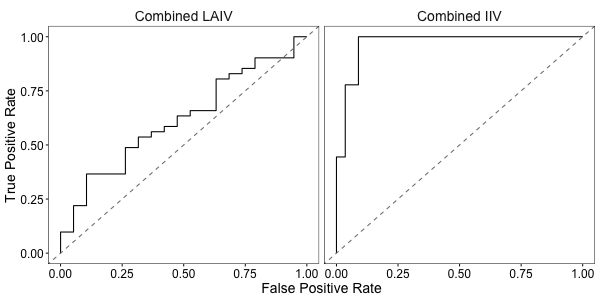

In [16]:
%%R -w 600 -h 300
source("custom_theme.R")
roc_files <- list.files(".", pattern = "roc_curve_df.csv", recursive = TRUE, full.names = TRUE)
combined_roc_df <- map_df(roc_files, ~ read_csv(.x,show_col_types = FALSE)) %>%
  mutate(Antigen = str_c("Combined ",Antigen)) %>%
  mutate(Antigen = factor(Antigen,levels=c("Combined LAIV","Combined IIV")))
ggplot(combined_roc_df, aes(fpr, tpr)) +
  geom_path() +
  facet_wrap(~Antigen,ncol = 2) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "grey50") +
  theme_custom() +
  theme(axis.text = element_text(color="black", size = 12), axis.title = element_text(color = "black",size = 14), 
  strip.text = element_text(size = 14)) +
  ylab("True Positive Rate") +
  xlab("False Positive Rate")

## Plot SHAP summary plot for IIV

Orientation inferred to be along y-axis; override with
`position_quasirandom(orientation = 'x')`


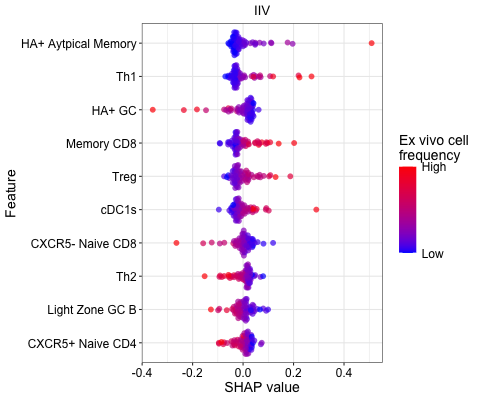

In [91]:
%%R -h 400
iiv_shap_file <- list.files(".", pattern = "IIV_shap_feature_values_long.csv", recursive = TRUE, full.names = TRUE)

iiv_shap_df <- read_csv(iiv_shap_file,show_col_types = FALSE) %>%
  group_by(variable) %>%
  mutate(color = scales::rescale(cell_composition, to = c(0, 1))) %>%
  dplyr::mutate(variable = as.character(variable))

iiv_shap_top10_vars <- iiv_shap_df %>%
  summarise(mean_abs_shap_value = mean(abs(shap_value))) %>% 
  arrange(mean_abs_shap_value) %>%
  tail(n=10) %>%
  pull(variable)
  
iiv_shap_df_top10 <- iiv_shap_df %>%
  filter(variable %in% iiv_shap_top10_vars) %>%
  mutate(variable = factor(variable, levels=iiv_shap_top10_vars))

ggplot(iiv_shap_df_top10, aes(shap_value, variable)) +
  geom_quasirandom(aes(color=color),size=2.75, alpha=0.7, stroke=0) +
  scale_color_gradient(low="blue",high = "red", name="Ex vivo cell\nfrequency",
                         limits=c(0,1),
                         breaks=c(0,1),
                         labels=c("Low","High")) +
  theme_bw() +
  theme(axis.text = element_text(color="black", size = 12), axis.title = element_text(color = "black",size = 14),
  plot.title = element_text(hjust = 0.5),legend.text = element_text(size = 12), legend.title = element_text(size=14)) +
  ylab("Feature") +
  xlab("SHAP value") +
  ggtitle("IIV")